# Generative Adversarial Networks

This tutorial is based on the Google course on [GANs](https://developers.google.com/machine-learning/gan) (released under [Creative Commons Attribution 4.0 License](https://creativecommons.org/licenses/by/4.0/)) and the [TF-GAN Tutorial](https://github.com/tensorflow/gan/blob/master/tensorflow_gan/examples/colab_notebooks/tfgan_tutorial.ipynb) written by Joel Shor and David Westbrook (released under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)).

## Overview

[Generative Adversarial Networks](https://developers.google.com/machine-learning/gan), or GANs in short, are a class of generative models presented for the first time by [Ian J. Goodfellow and co-authors in 2014](https://arxiv.org/abs/1406.2661) where a neural network, the **generator**, learns to produce plausible data using the feedback of how another neural network, the **discriminator**, classifies the data created by the generator.

### Here are some potential applications in Biology:

- increasing resolution of Hi-C data (hicGAN, [Liu et al., 2019, Bioinformatics](https://academic.oup.com/bioinformatics/article/35/14/i99/5529246));
- training data augmentation: microscope images ([Baniukiewicz et al., 2019, Front. Comput. Sci.](https://www.frontiersin.org/articles/10.3389/fcomp.2019.00010/full))
- generate novel protein sequence (ProteinGAN, [Repecka et al., 2019, bioRxiv](https://www.biorxiv.org/content/10.1101/789719v2))
- in silico generation and augmentation of single-cell RNA-seq data ([Ghahramani et al., 2018, bioRxiv](https://www.biorxiv.org/content/10.1101/262501v2.full.pdf), [Marouf et al., 2020, Nat. Comm.](https://www.nature.com/articles/s41467-019-14018-z))
- generate privacy-preserving clinical data (for instance, for model training) ([Beaulieu-Jones et al., 2019, 
Circulation: Cardiovascular Quality and Outcomes](https://www.ahajournals.org/doi/full/10.1161/CIRCOUTCOMES.118.005122?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed))

Given a set of labelled data instances, if x is a data instance and y its label:
- **Discriminative models**, such as RF or CNN classifiers, discriminate between different kinds of data instances. They capture the conditional probability P(x|y);
- **Generative models**, such as GANs, generate new data instances that resemble the input data. They capture the conditional probability P(x,y) or P(x) if there are no labels.

Here is an example for a set of images of handwritten digits (such as [MNIST](https://wikipedia.org/wiki/MNIST_database)):

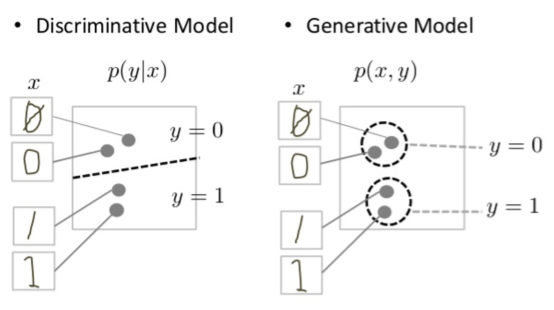

A GAN has two parts:

- The **generator** takes in input random noise and learns to generate data instances (for example, images) drawn from a probability distribution (the probability distribution of the image training set). The data instances created by the generator become negative training instances for the discriminator;


- The **discriminator** learns to distinguish the generator's fake data from real data. The discriminator penalizes the generator for producing implausible results.

## Step1: training the Discriminator

The discriminator is a simple classifier:
- Real data are positive examples
- Fake data produced by the Generator are negative examples

In this step:
- the generator does not train
- the discriminator only uses the discriminator loss

The discriminator weights are updated through backpropagation from the discriminator loss through the discriminator network. The discriminator loss penalizes the discriminator for misclassifying a real instance as fake or a fake instance as real.

## Step 2: training the generator

The generator learns to create fake data by incorporating feedback from the discriminator.
It learns to make the discriminator classify its output as real.

The Generator loss penalizes the generator for failing to fool the discriminator.

In this step only the Generator weights are updated, the Discriminator weights are left unchanged.

## GAN Training

Training proceeds in alternating periods:
1. The discriminator trains for one or more epochs.
2. The generator trains for one or more epochs.
3. Repeat steps 1 and 2

Convergence is hard to identify:
- as the generator improves, the discriminator feedback gets less meaningful over time
- if the generator succeeds, the discriminator accuracy will be 50% (like if it would flip a coin to decide)
- if the training continues past this point, the generator gets random feedback from the discriminator and will train on junk data
therefore, GAN convergence is a fleeting state, rather than a stable state.

## Using the TensorFlow-GAN library

Let us see how we can define, train, and evaluate a GAN using the TensorFlow-GAN library [TF-GAN](https://github.com/tensorflow/gan).
To gain familiarity with TensorFlow you can look at the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

We first import the required Python modules:

In [11]:
# Check that imports for the rest of the file work.
import tensorflow as tf
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)  # Disable noisy outputs.

Let us first check the version of TensorFlow:

In [12]:
tf.__version__

'2.0.0'

and the version of TensorFlow-GAN:

In [13]:
tfgan.__version__

'2.0.0'

In this notebook, you will learn how to use TF-GAN Estimators to train a GAN to generate images that are sampled from the same probability distribution of an image dataset.

These new images could be used to augment a training set to mitigate a **class imbalance**, when the data instances of a certain class are much fewer than those belonging to other classes.

## Unconditional MNIST with GANEstimator

This exercise uses TF-GAN's GANEstimator and the MNIST dataset to create a GAN for generating fake handwritten digits.

### MNIST

The [MNIST dataset](https://wikipedia.org/wiki/MNIST_database) contains tens of thousands of images of handwritten digits. We'll use these images to train a GAN to generate fake images of handwritten digits.

### GANEstimator

TensorFlow's Estimator API that makes it easy to train models. TF-GAN offers `GANEstimator`, an Estimator for training GANs.

### Input Pipeline

We set up our input pipeline by defining an `input_fn`. in the "Train and Eval Loop" section below we pass this function to our GANEstimator's `train` method to initiate training.  The `input_fn`:

1.  Generates the random inputs for the generator.
2.  Uses `tensorflow_datasets` to retrieve the MNIST data.
3.  Uses the tf.data API to format the data.

Let us take a look at the benchmark datasets available with the library TensorFlow Datasets.

In [14]:
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_natura

Here, we will consider the [MNIST](https://www.tensorflow.org/datasets/catalog/mnist) dataset.

Once you finish this tutorial, you can also experiment with another dataset, for instance the [colorectal_histology dataset](https://www.tensorflow.org/datasets/catalog/colorectal_histology).

In [15]:
def input_fn(mode, params):
    
  assert 'batch_size' in params
  assert 'noise_dims' in params
  
  bs = params['batch_size']
  nd = params['noise_dims']
    
  # the flags in tf.estimator.ModeKeys keeps track whether we are in training (.TRAIN)
  # or prediction (.PREDICT) mode
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random.normal([bs, nd])))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist', split=split, data_dir='./tmp')
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

Download the data and sanity check the inputs.

Shape of the image array = (100, 28, 28, 1)


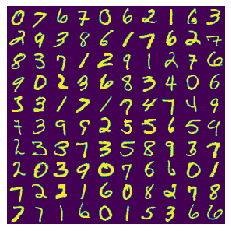

In [19]:
params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(tfds.as_numpy(ds))[1]

print('Shape of the image array = {}'.format(numpy_imgs.shape))
    
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()

### Neural Network Architecture

To build our GAN we need two separate networks:

*  A generator that takes input noise and outputs generated MNIST digits
*  A discriminator that takes images and outputs a probability of being real or fake

We define functions that build these networks. In the GANEstimator section below we pass the builder functions to the `GANEstimator` constructor. `GANEstimator` handles hooking the generator and discriminator together into the GAN. 

To initialize the weights, we use the [Glorot uniform initializer](https://keras.io/initializers/), also called Xavier uniform initializer ([Glorot et al., 2010](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)).

We define the dense (fully connected) layer:

In [30]:
def _dense(inputs, units, l2_weight):
  return tf.compat.v1.layers.dense(
      inputs, units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

The Batch normalization layer:

In [31]:
def _batch_norm(inputs, is_training):
  return tf.compat.v1.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

The following operation is the [transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose) (gradient) of conv2d: 

In [32]:
def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.compat.v1.layers.conv2d_transpose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=tf.nn.relu, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

And the 2D convolutional layer:

In [33]:
def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.compat.v1.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=None, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

Now we can define the **generator**:

In [54]:
def unconditional_generator(noise, mode, weight_decay=2.5e-5):
  """Generator to produce unconditional MNIST images."""
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _dense(noise, 1024, weight_decay)
  # print(net.shape)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = _dense(net, 7 * 7 * 256, weight_decay)
  # print(net.shape)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = tf.reshape(net, [-1, 7, 7, 256])
  # print(net.shape)
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  # print(net.shape)
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  # Make sure that generator output is in the same range as `inputs`
  # ie [-1, 1].
  net = _conv2d(net, 1, 4, 1, 0.0)
  # print(net.shape)
  net = tf.tanh(net)

  return net

In [55]:
# to test the generator
x = tf.random.normal([params['batch_size'], params['noise_dims']])
print(x.shape)
i = unconditional_generator(x, tf.estimator.ModeKeys.TRAIN)
i.shape

(100, 64)


TensorShape([100, 28, 28, 1])

and we define the **discriminator**:

We use the non-linear function [Leaky ReLU](https://ai.stanford.edu/%7Eamaas/papers/relu_hybrid_icml2013_final.pdf)  for the layers of the discriminator.

In [56]:
_leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

In [24]:
def unconditional_discriminator(img, unused_conditioning, mode, weight_decay=2.5e-5):
  del unused_conditioning
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _conv2d(img, 64, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = _conv2d(net, 128, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = tf.compat.v1.layers.flatten(net)
  
  net = _dense(net, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = _leaky_relu(net)
  
  net = _dense(net, 1, weight_decay)

  return net

### Evaluating Generative Models, and evaluating GANs


TF-GAN provides some standard methods of evaluating generative models. In this example, we measure:

*  Inception Score: called `mnist_score` below.
*  Frechet Inception Distance

We apply a pre-trained classifier to both the real data and the generated data calculate the *Inception Score*.  The Inception Score is designed to measure both quality and diversity. See [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) by Salimans et al. for more information about the Inception Score. [Here](https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/) is a tutorial on how to implement the Inception Score.

*[Frechet](https://reader.elsevier.com/reader/sd/pii/0047259X8290077X?token=ADEA650E997FB82F8F45DEDE5B3CD3BFA1442FC0C88F4ABA8865D974D827D43A84A49DEA8BC4DF1E03FEB20498CA2633) Inception Distance* measures how close the generated image distribution is to the real image distribution.  See [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) by Heusel et al. for more information about the Frechet Inception distance. In particular, the [Appendix A1](https://arxiv.org/pdf/1706.08500.pdf).

In [90]:
# from tensorflow_gan.examples.mnist import util as eval_util
# import os

# def get_eval_metric_ops_fn(gan_model):
#   real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
#   gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
#   real_mnist_score = eval_util.mnist_score(gan_model.real_data)
#   generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
#   frechet_distance = eval_util.mnist_frechet_distance(
#       gan_model.real_data, gan_model.generated_data)
#   return {
#       'real_data_logits': tf.compat.v1.metrics.mean(real_data_logits),
#       'gen_data_logits': tf.compat.v1.metrics.mean(gen_data_logits),
#       'real_mnist_score': tf.compat.v1.metrics.mean(real_mnist_score),
#       'mnist_score': tf.compat.v1.metrics.mean(generated_mnist_score),
#       'frechet_distance': tf.compat.v1.metrics.mean(frechet_distance),
#   }

In [10]:
from tensorflow_gan.python.eval import inception_metrics as eval_util
import os

def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  real_inception_score = eval_util.inception_score(gan_model.real_data)
  generated_inception_score = eval_util.inception_score(gan_model.generated_data)
  frechet_distance = eval_util.frechet_inception_distance(
      gan_model.real_data, gan_model.generated_data)
  return {
      'real_data_logits': tf.compat.v1.metrics.mean(real_data_logits),
      'gen_data_logits': tf.compat.v1.metrics.mean(gen_data_logits),
      'real_mnist_score': tf.compat.v1.metrics.mean(real_mnist_score),
      'mnist_score': tf.compat.v1.metrics.mean(generated_mnist_score),
      'frechet_distance': tf.compat.v1.metrics.mean(frechet_distance),
  }

### GANEstimator

The `GANEstimator` assembles and manages the pieces of the whole GAN model. The `GANEstimator` constructor takes the following compoonents for both the generator and discriminator:

*  Network builder functions: we defined these in the "Neural Network Architecture" section above.
*  Loss functions: here we use the [wasserstein loss](https://arxiv.org/abs/1701.07875) for both.
*  Optimizers: here we use `tf.train.AdamOptimizer` for both generator and discriminator training.

### Wasserstein Loss

By default, TF-GAN uses the [Wasserstein loss](https://developers.google.com/machine-learning/gan/loss).

This loss function depends on a modification of the GAN scheme (called "Wasserstein GAN" or "WGAN") in which the discriminator does not actually classify instances. For each instance it outputs a number. This number does not have to be less than one or greater than 0, so we can't use 0.5 as a threshold to decide whether an instance is real or fake. Discriminator training just tries to make the output bigger for real instances than for fake instances.

Because it can't really discriminate between real and fake, the WGAN discriminator is actually called a "critic" instead of a "discriminator". This distinction has theoretical importance, but for practical purposes we can treat it as an acknowledgement that the inputs to the loss functions don't have to be probabilities.

The loss functions themselves are deceptively simple:

Critic Loss: *D(x) - D(G(z))*

The discriminator tries to maximize this function. In other words, it tries to maximize the difference between its output on real instances and its output on fake instances.

Generator Loss: *D(G(z))*

The generator tries to maximize this function. In other words, It tries to maximize the discriminator's output for its fake instances.

In these functions:

- *D(x)* is the critic's output for a real instance.
- *G(z)* is the generator's output when given noise z.
- *D(G(z))* is the critic's output for a fake instance.
- The output of critic D does not have to be between 1 and 0.
- The formulas derive from the [earth mover distance](https://en.wikipedia.org/wiki/Earth_mover's_distance) between the real and generated distributions.

In TF-GAN, see [wasserstein_generator_loss and wasserstein_discriminator_loss](https://github.com/tensorflow/gan/blob/master/tensorflow_gan/python/losses/losses_impl.py) for implementations.

In [91]:
train_batch_size = 32 #@param
noise_dimensions = 64 #@param
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param

def gen_opt():
  gstep = tf.compat.v1.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.compat.v1.train.AdamOptimizer(lr, 0.5)

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=unconditional_generator,
    discriminator_fn=unconditional_discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer=gen_opt,
    discriminator_optimizer=tf.compat.v1.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn
)

### Train and eval loop

The `GANEstimator`'s `train()` method initiates GAN training, including the alternating generator and discriminator training phases.

The loop in the code below calls `train()` repeatedly in order to periodically display generator output and evaluation results. But note that the code below does not manage the alternation between discriminator and generator: that's all handled automatically by `train()`.

Time since start: 9.07 min
Trained from step 0 to 500 in 0.92 steps / sec
Average discriminator output on Real: -14.39  Fake: -13.23
Inception Score: 5.57 / 8.35  Frechet Distance: 88.97


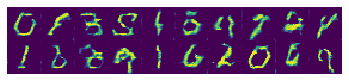

Time since start: 18.63 min
Trained from step 500 to 1000 in 0.91 steps / sec
Average discriminator output on Real: -6.11  Fake: -6.50
Inception Score: 6.48 / 8.35  Frechet Distance: 64.40


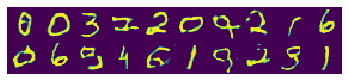

Time since start: 28.42 min
Trained from step 1000 to 1500 in 0.89 steps / sec
Average discriminator output on Real: -11.25  Fake: -13.39
Inception Score: 7.12 / 8.35  Frechet Distance: 61.07


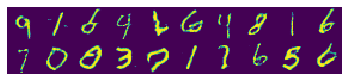

Time since start: 37.80 min
Trained from step 1500 to 2000 in 0.93 steps / sec
Average discriminator output on Real: -5.89  Fake: -7.10
Inception Score: 7.03 / 8.35  Frechet Distance: 61.37


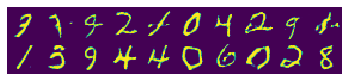

Time since start: 47.51 min
Trained from step 2000 to 2500 in 0.90 steps / sec
Average discriminator output on Real: 33.52  Fake: 31.27
Inception Score: 7.24 / 8.35  Frechet Distance: 56.75


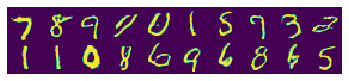

Time since start: 57.37 min
Trained from step 2500 to 3000 in 0.88 steps / sec
Average discriminator output on Real: 55.03  Fake: 57.46
Inception Score: 7.27 / 8.35  Frechet Distance: 59.73


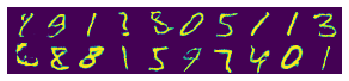

Time since start: 67.23 min
Trained from step 3000 to 3500 in 0.89 steps / sec
Average discriminator output on Real: 25.58  Fake: 21.16
Inception Score: 7.41 / 8.35  Frechet Distance: 55.46


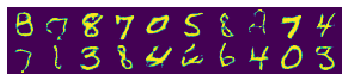

Time since start: 76.86 min
Trained from step 3500 to 4000 in 0.90 steps / sec
Average discriminator output on Real: 135.66  Fake: 128.72
Inception Score: 7.36 / 8.35  Frechet Distance: 58.65


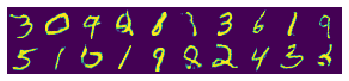

Time since start: 86.80 min
Trained from step 4000 to 4500 in 0.87 steps / sec
Average discriminator output on Real: 66.25  Fake: 60.70
Inception Score: 7.38 / 8.35  Frechet Distance: 59.09


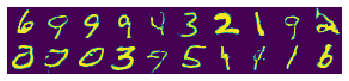

Time since start: 96.05 min
Trained from step 4500 to 5000 in 0.94 steps / sec
Average discriminator output on Real: 219.93  Fake: 203.96
Inception Score: 7.40 / 8.35  Frechet Distance: 59.96


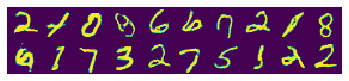

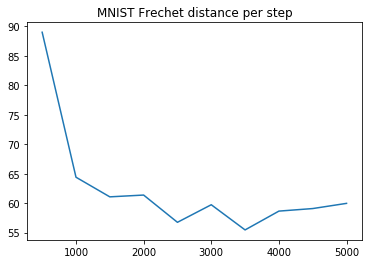

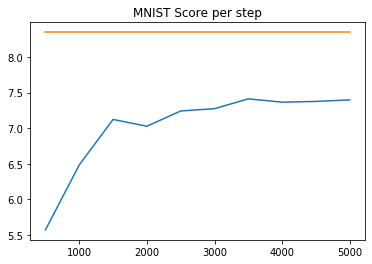

In [95]:
# Disable noisy output.
tf.autograph.set_verbosity(0, False)

import time
steps_per_eval = 500 #@param
max_train_steps = 5000 #@param
batches_for_eval_metrics = 100 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()

while cur_step < max_train_steps:
    
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
    
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])

  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.estimator.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()
  
  
# Plot the metrics vs step.
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title('MNIST Score per step')
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()